In [222]:
'''
Method developed by Anoop Praturu: https://www.biorxiv.org/content/10.1101/2022.10.12.511940v1
Code from Anoop Praturu on Oct 2021
Move from pystan to cmdstanpy based on suggestions by Milo Julis
Edited by Mingchen Yao on May 26 2023
'''

import numpy as np
import diptest  
import matplotlib.pyplot as plt
import cmdstanpy as stan
import scipy.stats as stats
import pickle
import seaborn as sns
%matplotlib inline

import pandas as pd

import plotly.express as px
from matplotlib import rcParams
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [44]:
import sys
print(sys.executable)

/Users/iuliarusu/miniconda3/envs/HMDS/bin/python


In [ ]:
# # if there is anything wrong with comstan: re-install it. Otherwise don't run this cell
# from cmdstanpy import install_cmdstan
# install_cmdstan(overwrite = True)

In [ ]:
!python --version

# Functions for Generating Synthetic Data

In [2]:
#returns hyperbolic distance between vectors in poincare ball
def poincare_dist(v1, v2):
    sq = np.sum(np.square(v1-v2))
    r1 = np.sum(np.square(v1))
    r2 = np.sum(np.square(v2))
    inv = 2.0*sq/((1.0-r1)*(1.0-r2))
    return np.arccosh(1.0 + inv)

#return NxN symmetric distance matrix from poincare coordinates
def get_dmat(p_coords):
    N = p_coords.shape[0]
    dists = np.zeros((N, N))
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            dists[i][j] = poincare_dist(p_coords[i], p_coords[j])
            dists[j][i] = dists[i][j]
    return dists

In [ ]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=5; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_dim = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_dim[j][i] = mat_dim[i][j]
mat_dim = 2.0*mat_dim/np.max(mat_dim)

# Code for fitting Bayesian Model

In [3]:
path = '/Users/iuliarusu/Documents/Sharpee/HMDS-example/model/'
ltz_m = stan.CmdStanModel(stan_file=path+'lorentz.stan')

# Filtered Unclustered (Stim)


In [254]:
np.random.seed(42)

# Load the filtered unclustered data
file_path = '/Users/iuliarusu/Documents/Sharpee/filtered_unclustred.csv'
filtered_unclustred = pd.read_csv(file_path)

# Split data by worm_id and select a random subset of 50 cells
unclustered_dfs = []
for i in range(7):
    df = filtered_unclustred[filtered_unclustred['worm_id'] == i].iloc[:, :-1]
    
    # # Select a random sample of 50 rows (cells)
    # if len(df) >= 50:
    #     df = df.sample(n=50, random_state=42)
    
    unclustered_dfs.append(df)

In [256]:
unclustered_dfs[5].shape

(110, 1600)

# Buffer

In [223]:
scaler = MinMaxScaler()

In [224]:
Benzaldehyde_3_Worm1_Buffer = pd.read_csv('/Users/iuliarusu/Documents/Sharpee/Buffer_control_data/Benzaldehyde_10e-3_Worm1_Buffer.csv')
Benzaldehyde_3_Worm1_Buffer = Benzaldehyde_3_Worm1_Buffer.T
# Scale each row individually
Benzaldehyde_3_Worm1_Buffer_scaled = Benzaldehyde_3_Worm1_Buffer.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1)

# Convert back to a DataFrame
Benzaldehyde_3_Worm1_Buffer_scaled = pd.DataFrame(Benzaldehyde_3_Worm1_Buffer_scaled.tolist(), index=Benzaldehyde_3_Worm1_Buffer.index, columns=Benzaldehyde_3_Worm1_Buffer.columns)

In [225]:
corr_matrix = Benzaldehyde_3_Worm1_Buffer_scaled.T.corr()
distance_matrix = 1 - corr_matrix
distance_matrix_squaredp = (1 - corr_matrix**2) * 2

In [257]:
corr_matrix = unclustered_dfs[4].T.corr()
distance_matrix = 1 - corr_matrix
distance_matrix_squaredp = (1 - corr_matrix**2) * 2

In [258]:
corr_matrix.shape

(110, 110)

In [259]:
#dictionary to specify input to simulation

# dat={'N':100, 'D':5, 'deltaij':mat_dim}
dat = {'N': 110 , 'D': 3 , 'deltaij':distance_matrix_squaredp}
#run optimizer
model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)

01:44:04 - cmdstanpy - INFO - Chain [1] start processing


01:50:00 - cmdstanpy - INFO - Chain [1] done processing


In [260]:
# build result 
hyp_emb = {'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda')}

# # and save
# fdname = './emb5d.pickle'
# with open(fdname,'wb') as file:
#     pickle.dump(hyp_emb, file,  protocol=pickle.HIGHEST_PROTOCOL)

01:50:22 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


In [ ]:
# # load existing results
# fdname = './emb5d.pickle'
# with open(fdname, 'rb') as file:
#     hyp_emb = pickle.load(file)

## Some utility functions for post-processing the simulation output

In [229]:
def d_lor(t1, t2, E1, E2):
    return np.arccosh(t1*t2 - np.dot(E1, E2))

#returns embedding distance matrix from optimization fit
def get_embed_dmat(fit):
    N = fit['euc'].shape[0]
    fit_ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))

    fit_mat = np.zeros((N, N))

    for i in np.arange(N):
        for j in np.arange(i+1,N):
            fit_mat[i][j] = d_lor(fit_ts[i], fit_ts[j], fit['euc'][i], fit['euc'][j])
            fit_mat[j][i] = fit_mat[i][j]
            
    return fit_mat

#return poincare coordinates
def get_poin(fit):
    ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))
    return (fit['euc'].T / (ts + 1)).T

In [230]:
def process_sim(fit):
    fit['emb_mat'] = get_embed_dmat(fit)/fit['lambda']
    fit['pcoords'] = get_poin(fit)
    fit['radii'] = 2.0*np.arctanh(np.sqrt(np.sum(np.square(fit['pcoords']), axis=1)))

In [261]:
#run this function after running the optimizer to process the output data into more usable forms
process_sim(hyp_emb)

In [262]:
#curvature (or radius)
hyp_emb['lambda']

4.82177

In [263]:
#poincare embedding coordinates
hyp_emb['pcoords']

array([[ 0.40671781,  0.04685631,  0.88769041],
       [ 0.44413811,  0.50956083,  0.71772646],
       [ 0.62944432,  0.14829698,  0.7275721 ],
       [ 0.72723981,  0.03497959,  0.65181991],
       [ 0.93853351, -0.27722328,  0.123298  ],
       [-0.75580777,  0.27395484, -0.56765022],
       [-0.69204872,  0.69974432,  0.03582068],
       [-0.89253386, -0.21778037, -0.35036774],
       [-0.89226812, -0.26520912, -0.30680414],
       [-0.96942783,  0.13870668, -0.09002404],
       [-0.94000696,  0.06195573, -0.28766169],
       [-0.16773429,  0.89101742, -0.39570967],
       [-0.66721789,  0.7060179 ,  0.09773839],
       [-0.82573342,  0.48632465, -0.18121627],
       [ 0.45431423,  0.48081951,  0.72564741],
       [ 0.65033135, -0.04545027, -0.74408389],
       [-0.91462664, -0.18551728, -0.31013896],
       [ 0.49790053, -0.42785353,  0.70313812],
       [-0.85288701,  0.41411666, -0.21051865],
       [-0.77873967,  0.49029532, -0.32449601],
       [-0.36663207, -0.14854918, -0.907

In [264]:
w5_notincluster_pcoords = hyp_emb['pcoords']
%store w5_notincluster_pcoords 

Stored 'w5_notincluster_pcoords' (ndarray)


In [97]:
#emebdding uncertainties
hyp_emb.keys()

dict_keys(['euc', 'sig', 'lambda', 'emb_mat', 'pcoords', 'radii'])

# Shepard Diagram

In [246]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [ ]:
# color brewer paisley hex color references
#8dd3c7
#ffffb3
#bebada
#fb8072
#80b1d3

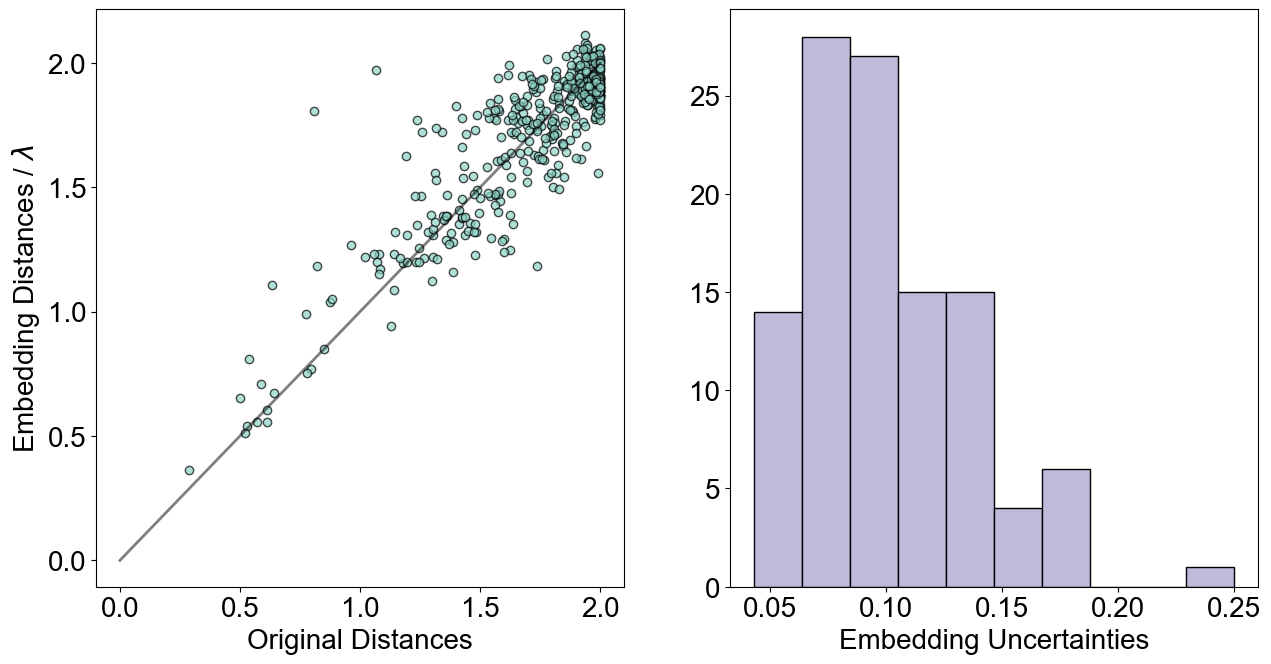

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(distance_matrix_squaredp.values[np.triu_indices(29, k=1)], hyp_emb['emb_mat'][np.triu_indices(29, k=1)], c='#8dd3c7', edgecolor='black', alpha=0.7) #cornflowerblue, lightcoral
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=2, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb['sig'], color ='#bebada', edgecolor='black') #cornflowerblue, lightcoral
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

# plt.savefig('/Users/iuliarusu/Documents/Sharpee/final_images/figure2/not_clustered_sheppard.svg', format='svg', bbox_inches='tight')



In [266]:
hyperbolic_df= pd.DataFrame(hyp_emb['pcoords'], columns=['x', 'y', 'z'])



In [ ]:
#cell type label column
column = ['ON'] * (ON_0.shape[0]) + ['OFF'] * (OFF_0.shape[0]) + ['AVA'] * (AVA_0.shape[0]) + ['RME'] * (RME_0.shape[0]) + ['SMDV'] * (SMDV_0.shape[0]) + ['SMDD'] * (SMDD_0.shape[0])
cell_type = np.array(column)
hyperbolic_df['cluster labels'] = cell_type.T


In [ ]:
#8dd3c7
#ffffb3
#bebada
#fb8072
#80b1d3

In [ ]:
hyperbolic_df

In [273]:


# Create a scatter plot
# fig = px.scatter_3d(data_frame = hyperbolic_df, x= 'x', y = 'y', z= 'z', title='AVA and RME: Stimulus 0', color = 'cluster labels') #cornflowerblue, lightcoral

fig = px.scatter_3d(data_frame = hyperbolic_df, x= 'x', y = 'y', z= 'z', title='Control W1' ) #cornflowerblue, lightcoral
fig.update_layout(
    scene=dict(
        xaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
        yaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
        zaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
        )
)
fig.update_traces(marker=dict(color='#80b1d3', size=8, opacity = 0.8))

fig.show()

In [ ]:
fig = px.scatter_3d(
    data_frame=hyperbolic_df, 
    x='x', 
    y='y', 
    z='z', 
     
    # text='cluster labels',  # assuming 'labels' column contains the point labels
    # title='ON and OFF Neurons',
    labels={'x': 'X', 'y': 'Y', 'z': 'Z'},
    
)

fig.update_layout(
    scene=dict(
        xaxis=dict(
            tickvals=[-1, -0.5, 0, 0.5, 1],
            ticktext=['-1', '-0.5', '0', '0.5', '1'],
            title=dict(text='X', font=dict(size=20)),
            tickfont=dict(size=15)
        ),
        yaxis=dict(
            tickvals=[-1, -0.5, 0, 0.5, 1],
            ticktext=['-1', '-0.5', '0', '0.5', '1'],
            title=dict(text='Y ', font=dict(size=20)),
            tickfont=dict(size=15)
            
        ),
        zaxis=dict(
            tickvals=[-1, -0.5, 0, 0.5, 1],
            ticktext=['-1', '-0.5', '0', '0.5', '1'],
            title=dict(text='Z ', font=dict(size=20)),
            tickfont=dict(size=15)
            
        )
    ),
    legend=dict(
        title=dict(text='Cluster Labels', font=dict(size=12)),
        font=dict(size=10)
    # ),
    # title=dict(
    #     text='ON and OFF Neurons',
    #     font=dict(size=15)
    ),
    margin=dict(l=20, r=20, b=90, t=40),
    autosize=True,
    width=700,
    height=500
)

# Customize marker size and opacity for better visualization
fig.update_traces(marker=dict(size=10, opacity=0.8, color='#8dd3c7' ))




fig.show()


# Fitting For Dimension

Suppose we did not know a-priori that the data was 5D? This is usually the case

## Fit the model across a range of dimensions

In [267]:
all_fits = []
for d in np.arange(2,10):
    dat={'N':110, 'D':d, 'deltaij':distance_matrix_squaredp}
    #run optimizer
    model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)
    all_fits.append({'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda'), 't':model.time})




01:57:00 - cmdstanpy - INFO - Chain [1] start processing


02:00:19 - cmdstanpy - INFO - Chain [1] done processing
02:00:19 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
02:00:19 - cmdstanpy - INFO - Chain [1] start processing
02:02:39 - cmdstanpy - INFO - Chain [1] done processing
02:02:39 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
02:02:39 - cmdstanpy - INFO - Chain [1] start processing
02:02:57 - cmdstanpy - INFO - Chain [1] done processing
02:02:57 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
02:02:57 - cmdstanpy - INFO - Chain [1] start processing
02:04:08 - cmdstanpy - INFO - Chain [1] done processing
02:04:08 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_v

In [268]:
model.stan_variable('lambda')

02:06:22 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


2.02479

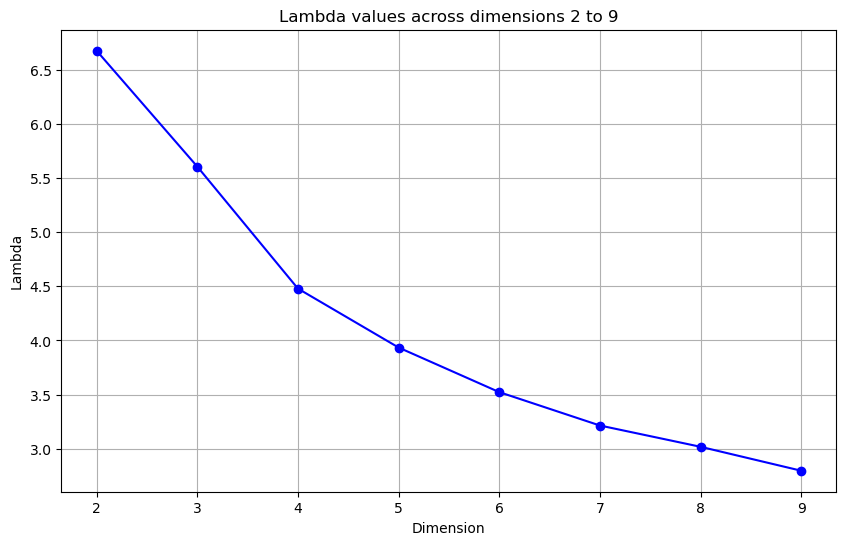

In [240]:
# Extract lambda values from all_fits for dimensions 2 to 9
lambda_values = [fit['lambda'] for fit in all_fits]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), lambda_values, marker='o', linestyle='-', color='b')
plt.xlabel("Dimension")
plt.ylabel("Lambda")
plt.title("Lambda values across dimensions 2 to 9")
plt.xticks(range(2, 10))  # Set x-axis ticks to reflect the dimensions 2 through 9
plt.grid(True)
plt.show()

In [220]:
all_fits[7]['t']

(50,)

In [ ]:
#access the correct iteration 
iteration = all_fits[6]['t']


iteration

In [ ]:
model.time.shape

In [ ]:
#calculate radii based on time parameter
radii = np.arccosh(iteration)

In [ ]:
radii

In [ ]:
w_1_radii = radii
%store w_1_radii

In [ ]:
#DIP analysis of radii
dip, pval = diptest.diptest(radii)

In [ ]:
dip, pval

In [ ]:
all_fits[0]['sig']

In [22]:
#return negative log likelihood of fit
def MDS_lkl(fit, dmat):
    lkl = 0;
    N = fit['sig'].shape[0]
    
    sigs = fit['sig']
    lam = fit['lambda']
    emb_mat = get_embed_dmat(fit)
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            seff = sigs[i]**2 + sigs[j]**2
            lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
    return lkl

#input: optimization fit and distance matrix
def BIC(fit, dmat):
    N,D = fit['euc'].shape
    n = 0.5*N*(N-1)
    k = N*D + N + 1.0 - 0.5*D*(D-1)
    
    return k*np.log(n) + 2.0*MDS_lkl(fit, dmat)

## Bayesian information criteria

There is a lot of formal Bayesian Theory behind this (see chapter 2 here https://urldefense.proofpoint.com/v2/url?u=https-3A__www.inference.org.uk_mackay_thesis.pdf&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=B8GeUuyHfxQP8MseZuhipQ&m=KVww4gh9-XOtp1LqNUc0K-PGXOX3bm2QsokPFlBG9Vs&s=UBtNEdIXatq_zFpG53nmPCLbCnlgIgWigHYhEnBRYyo&e= ), but essentially we are trying to find the minimal number of parameters to describe a dataset. If the data is 5D, we don't want to use 7 parameters to describe it. The BIC is like a cost function that rewards a model that has a better fit to the likelihood function, but penalizes models that increase the number of their parameters. The model which minimizes this function will thus have the ideal trade-off of being able to model the data well without introducing too many parameters and overfitting the data.

In [269]:
array_matrix = distance_matrix_squaredp.to_numpy()

In [270]:
all_BIC = [BIC(fit, array_matrix) for fit in all_fits]

In [271]:
all_BIC

[3519.2175462637124,
 -3055.4396577804287,
 -4065.654390824172,
 -4850.844035656999,
 -5040.179285982322,
 -5060.09576204032,
 -4939.141955703761,
 -4871.6730717664705]

In [203]:
min_BIC = (np.argmin(all_BIC)) + 2
min_BIC

4

In [204]:
#lambda extracted for specific dimension
optimal_lambda = min_BIC - 2
all_fits[optimal_lambda]['lambda']

3.74483

In [134]:
bics= [5, 5, 5, 3, 5, 6, 3]
avg_bics = np.average(bics)
avg_bics

4.571428571428571

As you can see the BIC is minimized at the true dimension of 5. Any more parameters would have been redundant, any less would not have properly fit the data

Text(0, 0.5, 'BIC')

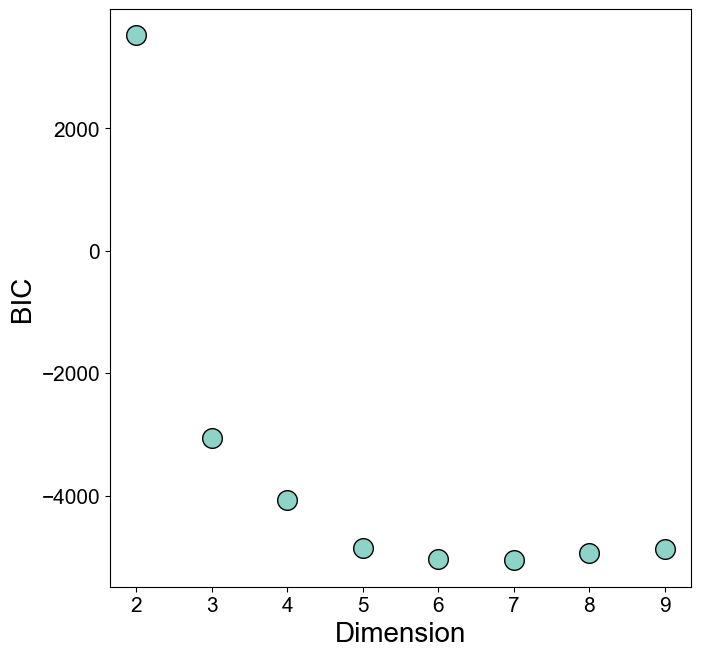

In [272]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

ax.scatter(np.arange(2,10), all_BIC, c = '#8dd3c7', edgecolor = 'black', s = 200) #cornflowerblue, lightcoral
ax.set_xlabel('Dimension', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('BIC', fontsize=20)

# plt.savefig('/Users/iuliarusu/Documents/Sharpee/final_images/figure2/buffer_bic.svg', format='svg', bbox_inches='tight')

# Re-Running the optimizer
Lets start by generating some 2D data

What is the purpose of re-running?

In [ ]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=2; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_2D = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_2D[j][i] = mat_2D[i][j]
mat_2D = 2.0*mat_2D/np.max(mat_2D)

In [ ]:
#dictionary to specify input to simulation
dat={'N':76, 'D':6, 'deltaij':distance_matrix_squaredp}
#run optimizer
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}

In [ ]:
process_sim(hyp_emb2D)

#### Most pts are well fit, but a few are poorly fit (the ones with high sigma) which adds a lot of scatter to the shepard diagram
#### The optimizer got caught in a false minimum

In [ ]:
#can't find 'emb_mat' parameter 
hyp_emb2D.keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(distance_matrix_squaredp[np.triu_indices(76, k=1)], hyp_emb2D['sig'][np.triu_indices(76, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)

### Strategy: randomize the positions of the poorly fit points, and then return the coordinates as the initial conditions to continue optimizing. This bumps the simulation out of the false minimium without destroying all of the work its already done

In [ ]:
#figure out which pts have high uncertainty, and randomize their coordinates without touching the rest of the points
N_refit = np.where(hyp_emb2D['sig'] > 0.3)[0].shape[0]
hyp_emb2D['euc'][np.where(hyp_emb2D['sig'] > 0.3)] = stats.norm.rvs(size=(N_refit,2))

In [ ]:
#re-reun the optimizer, but this time sepcify the initial condition by passing the previous simulation dictionary
dat={'N':100, 'D':2, 'deltaij':mat_2D}
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2,inits = hyp_emb2D)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}
# tst_2D = ltz_m.optimizing(data=dat, iter=250000, tol_rel_grad=1e2, init=tst_2D)

In [ ]:
process_sim(hyp_emb2D)

### We see that the fit is significantly better, although there are still a few poorly fit points. We could keep iterating the above process until all points are well fit.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(mat_2D[np.triu_indices(100, k=1)], hyp_emb2D['emb_mat'][np.triu_indices(100, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)